ในการพัฒนาระบบ AI สำหรับวินิจฉัยโรค ชนิดของข้อมูล Dataset ที่เราจะพบบ่อย ๆ หนึ่งในนั้นคือไฟล์ DICOM ซึ่งเป็นไฟล์สำหรับฟิล์มเ X-Ray, MRI, CT-Scan, Ultrasound ใน ep นี้เราจะมาทำความเข้าใจ ไฟล์ DICOM กันให้มากขึ้น

# DICOM คืออะไร

DICOM ย่อมาจาก Digital Imaging and Communications in Medicine เป็นมาตรฐานกลางในการสื่อสาร จัดเก็บ เรียกดู ประมวลผล จัดพิมพ์ และแสดงผลข้อมูลรูปภาพทางการแพทย์ กำหนดโดย องค์กรชื่อ National Electrical Manufacturers Association (NEMA)

มาตรฐาน DICOM ทำให้เราสามารถใช้ข้อมูลต่าง ๆ ร่วมกันได้ข้ามระบบ ระหว่างอุปกรณ์ต่าง ๆ ตั้งแต่ อุปกรณ์ถ่ายภาพ, PACS (Picture Archiving and Communication System), Workstation, VNAs และเครื่องพิมพ์ จากหลากหลายยี่ห้อ

ภายในไฟล์จะประกอบด้วยทั้งส่วน Header ที่เป็น Metada และส่วนของข้อมูลรูปภาพ ซึ่งมีได้มากกว่า 1 รูปต่อ 1 ไฟล์  เรามาดูตัวอย่างไฟล์ และรูปแบบข้อมูลในไฟล์กันดีกว่า

เช็ค GPU

In [1]:
! nvidia-smi

Thu Jun 11 09:09:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 0. Magic Command

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Install Library

Install Library ที่จำเป็น ในที่นี้เราจะใช้ โมดูล medical.imaging ของ [fastai2](https://www.bualabs.com/archives/4102/tutorial-fastai2-oxford-pets-dog-cat-37-class-machine-learning-deep-neural-networks-image-classification-ep-7/) 

In [0]:
# # Colab
# ! pip install fastai2 -q
# ! pip install pydicom -q
# ! pip install kornia -q

# 2. Import Library

Import Library ที่จำเป็น

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom
import kornia

import pandas as pd

In [0]:
set_seed(4422)

# 3. Dataset

ในเคสนี้เราจะใช้ Dataset ฟิล์ม X-Ray จาก Kaggle เหมือนใน ep ก่อน [พัฒนาโปรแกรม AI การแพทย์ วินิจฉัยภาวะปอดรั่ว Pneumothorax](https://www.bualabs.com/archives/2856/ai-diagnose-pneumothorax-read-chest-x-ray-radiograph-image-collapsed-lung-radiologist-triage-patient-classification-segment-medical-image-segmentation-ep-2/)

เราจะ Mount Drive ไปยัง Google Drive ที่เก็บ Token File ไว้

In [6]:
dataset = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'

# Google Colab
config_path = Path('/content/drive')
learner_path = config_path/"My Drive"
data_path_base = Path('/content/datasets/')

path = data_path_base/dataset

from google.colab import drive

drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*ในการจะ Download ข้อมูลจาก Kaggle ต้องใช้ Token ดูวิธีได้ใน ep ก่อน*

In [0]:
# !kaggle datasets download {dataset} -p "{path}" --unzip

ls ดูว่าได้ Folder อะไรมาบ้าง

In [8]:
path.ls()

(#4) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/train-rle.csv'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-test'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/pneumothorax'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train')]

ดูข้อมูลใน Training Folder

In [9]:
(path/'dicom-images-train').ls()

(#10712) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.5084.1517875186.345764'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1428.1517875167.716913'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.31928.1517875157.540241'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.14320.1517875251.282977'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.32562.1517875161.229896'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.13465.1517875245.453652'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-se

ใช้ฟังก์ชัน `get_dicom_files` ดึงไฟล์ทั้งหมดมาใส่ List ไว้ก่อน

In [10]:
items = get_dicom_files(path/'dicom-images-train')
items

(#10712) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.5084.1517875186.345764/1.2.276.0.7230010.3.1.3.8323329.5084.1517875186.345763/1.2.276.0.7230010.3.1.4.8323329.5084.1517875186.345765.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1428.1517875167.716913/1.2.276.0.7230010.3.1.3.8323329.1428.1517875167.716912/1.2.276.0.7230010.3.1.4.8323329.1428.1517875167.716914.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.31928.1517875157.540241/1.2.276.0.7230010.3.1.3.8323329.31928.1517875157.540240/1.2.276.0.7230010.3.1.4.8323329.31928.1517875157.540242.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.14320.1517875251.282977/1.2.276.0.7230010.3.1.3.832332

# 4. DICOM File

เลือกคนไข้ขึ้นมา 1 คน แล้วใช้ฟังก์ชัน `dcmread` เปิดไฟล์ขึ้นมาแสดงผลดูรูปภาพภายใน ไฟล์ DICOM

In [11]:
patient = 42
items[patient]

Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3594.1517875178.613997/1.2.276.0.7230010.3.1.3.8323329.3594.1517875178.613996/1.2.276.0.7230010.3.1.4.8323329.3594.1517875178.613998.dcm')

## 4.1 Image

ดูรูปภาพ

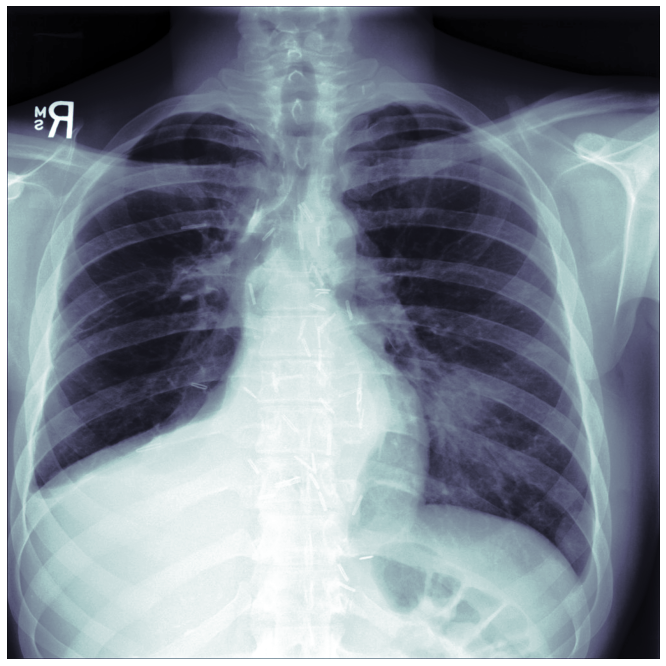

In [12]:
xray_sample = dcmread(items[patient])
xray_sample.show(figsize=(12, 12))

# 4.2 Metadata

ดู Metadata ในไฟล์ DICOM

In [13]:
xray_sample.as_dict()

{'AccessionNumber': '',
 'BitsAllocated': 8,
 'BitsStored': 8,
 'BodyPartExamined': 'CHEST',
 'Columns': 1024,
 'ConversionType': 'WSD',
 'HighBit': 7,
 'InstanceNumber': 1,
 'LossyImageCompression': '01',
 'LossyImageCompressionMethod': 'ISO_10918_1',
 'Modality': 'CR',
 'MultiPixelSpacing': 1,
 'PatientAge': '24',
 'PatientBirthDate': '',
 'PatientID': '56c91002-a433-4013-92be-be9588f78ea8',
 'PatientName': '56c91002-a433-4013-92be-be9588f78ea8',
 'PatientOrientation': '',
 'PatientSex': 'M',
 'PhotometricInterpretation': 'MONOCHROME2',
 'PixelRepresentation': 0,
 'PixelSpacing': 0.168,
 'PixelSpacing1': 0.168,
 'ReferringPhysicianName': '',
 'Rows': 1024,
 'SOPClassUID': '1.2.840.10008.5.1.4.1.1.7',
 'SOPInstanceUID': '1.2.276.0.7230010.3.1.4.8323329.3594.1517875178.613998',
 'SamplesPerPixel': 1,
 'SeriesDescription': 'view: PA',
 'SeriesInstanceUID': '1.2.276.0.7230010.3.1.3.8323329.3594.1517875178.613996',
 'SeriesNumber': 1,
 'SpecificCharacterSet': 'ISO_IR 100',
 'StudyDate': '

จะเห็นว่า มีหลายตัวที่น่าสนใจ เช่น 

* BitsStored เป็นตัวบอกว่ารูปภาพกี่ Bit อาจจะเป็น 8, 14, 16 Bit การแปลงเป็น 8 Bit x 3 Channel RGB เพื่อแสดงผลบนจอภาพ อาจจะทำให้สูญเสียข้อมูลได้
* PixelRepresentation บอกว่าข้อมูลเป็น Signed หรือ Unsigned
* img_max, img_mean, img_min บอกสถิติของข้อมูล Pixel

## 4.3 Pixels Data

ในเคสนี้ ขนาดของรูปภาพคือ 1024 x 1024 Pixel

In [14]:
xray_sample.pixels.shape

torch.Size([1024, 1024])

เป็นรูปภาพขาวดำ Grayscale 0-255

In [15]:
xray_sample.pixels.min(), xray_sample.pixels.max(), xray_sample.scaled_px.min(), xray_sample.scaled_px.max()

(tensor(4.), tensor(250.), tensor(4.), tensor(250.))

In [16]:
xray_sample.pixels[300:310, 400:410]

tensor([[166., 166., 166., 165., 165., 165., 167., 169., 170., 169.],
        [166., 166., 166., 167., 167., 168., 168., 168., 169., 168.],
        [165., 167., 168., 169., 168., 167., 167., 167., 168., 168.],
        [164., 167., 171., 171., 169., 166., 166., 166., 168., 168.],
        [166., 171., 175., 173., 168., 165., 167., 171., 172., 174.],
        [168., 172., 174., 173., 170., 169., 171., 175., 173., 175.],
        [171., 173., 174., 174., 173., 173., 176., 179., 176., 177.],
        [173., 173., 175., 175., 176., 177., 178., 180., 179., 179.],
        [175., 175., 176., 178., 179., 180., 180., 179., 182., 181.],
        [178., 179., 180., 181., 182., 182., 181., 180., 183., 182.]])

In [17]:
xray_sample.scaled_px[300:310, 400:410]

tensor([[166., 166., 166., 165., 165., 165., 167., 169., 170., 169.],
        [166., 166., 166., 167., 167., 168., 168., 168., 169., 168.],
        [165., 167., 168., 169., 168., 167., 167., 167., 168., 168.],
        [164., 167., 171., 171., 169., 166., 166., 166., 168., 168.],
        [166., 171., 175., 173., 168., 165., 167., 171., 172., 174.],
        [168., 172., 174., 173., 170., 169., 171., 175., 173., 175.],
        [171., 173., 174., 174., 173., 173., 176., 179., 176., 177.],
        [173., 173., 175., 175., 176., 177., 178., 180., 179., 179.],
        [175., 175., 176., 178., 179., 180., 180., 179., 182., 181.],
        [178., 179., 180., 181., 182., 182., 181., 180., 183., 182.]])

## 4.4 Histogram

ลองพล็อต Histogram จะเห็นว่า ข้อมูลมีบางระดับที่มากน้อยต่างกัน บางค่าก็น้อยมาก

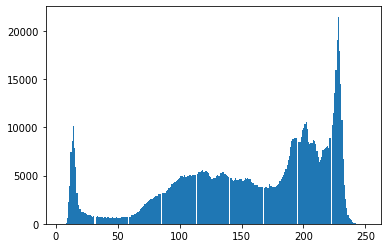

In [18]:
hist = plt.hist(xray_sample.pixels.reshape(-1).numpy(), bins=255)

## 4.5 Normalize

เราสามารถแบ่งข้อมูลออกเป็น Bins ตามความถี่ให้ข้อมูลกระจายออกไปทั่ว ๆ เป็นการ [Normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/)

In [19]:
bins = xray_sample.pixels.freqhist_bins()
bins.shape, bins

(torch.Size([98]),
 tensor([ 10.,  11.,  13.,  14.,  15.,  17.,  23.,  35.,  50.,  64.,  71.,  76.,
          80.,  84.,  87.,  90.,  93.,  95.,  98., 100., 102., 104., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131., 133.,
         135., 137., 139., 141., 144., 146., 148., 151., 153., 155., 157., 160.,
         162., 165., 168., 171., 173., 176., 179., 181., 183., 185., 187., 189.,
         190., 191., 193., 194., 195., 196., 197., 199., 200., 201., 202., 203.,
         204., 205., 206., 208., 209., 210., 211., 213., 215., 216., 217., 219.,
         220., 221., 223., 224., 225., 226., 227., 228., 229., 230., 231., 232.,
         234., 238.]))

แสดง Histogram อีกครั้ง จาก Bins ด้านบน จะเห็นว่ากระจายดีขึ้น โมเดลจะได้ทำงานง่ายขึ้น

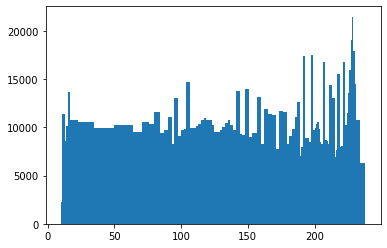

In [20]:
hist = plt.hist(xray_sample.pixels.reshape(-1).numpy(), bins=bins)

## 4.6 DICOM Windows

ในการวิเคราะห์ วินิจฉัยโรค โดยแพทย์ผู้ชำนาญการ เนื่องจากสายตาของมนุษย์ โดยทั่วไปสามารถแยกแยะได้แค่ประมาณ 100 ระดับสีเท่านั้น ในการแสดงผล จึงมีการแยกเฉพาะ Window ในช่วงข้อมูลต่าง ๆ มาแสดงผล ตามความหนาแน่นทางรังสี Radiodensity ตามช่วง Hounsfield scale ของอวัยวะที่เราสนใจ

In [21]:
dicom_windows

namespace(abdomen_soft=(400, 50), brain=(80, 40), brain_bone=(2800, 600), brain_soft=(375, 40), liver=(150, 30), lungs=(1500, -600), mediastinum=(350, 50), spine_bone=(1800, 400), spine_soft=(250, 50), stroke=(8, 32), subdural=(254, 100))

แสดงข้อมูล ใน Windows ต่าง ๆ เช่น เน้นปอด เน้นกระดูกสันหลัง

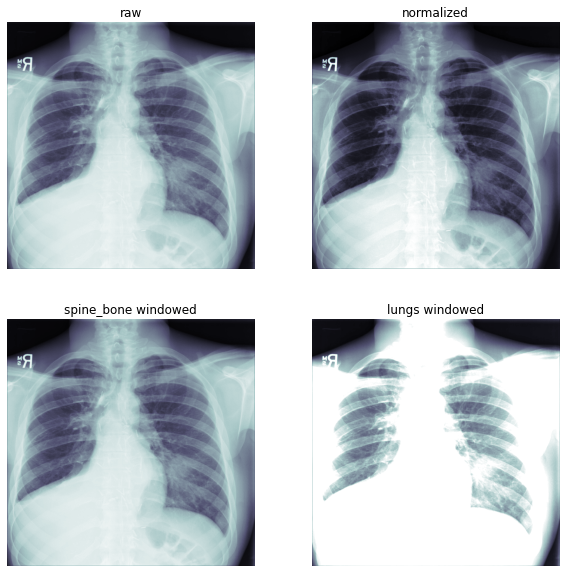

In [22]:
scales = False, True, dicom_windows.spine_bone, dicom_windows.lungs
titles = 'raw','normalized','spine_bone windowed','lungs windowed'
for s,a,t in zip(scales, subplots(2,2,imsize=5)[1].flat, titles):
    xray_sample.show(scale=s, ax=a, title=t)

ดูว่าข้อมูล Pixel ทั้งหมดใ อยู่ใน Window ที่กำหนดกี่เปอร์เซ็นต์

In [0]:
# xray_sample.pct_in_window??

In [24]:
xray_sample.pct_in_window(*dicom_windows.brain)

0.1132497787475586

In [25]:
xray_sample.pct_in_window(*dicom_windows.lungs)

0.42022228240966797

In [26]:
xray_sample.pct_in_window(*dicom_windows.mediastinum)

0.8750581741333008

เราสามารถ เอา Window มา Mask เอาเฉพาะส่วนที่เราสนใจได้

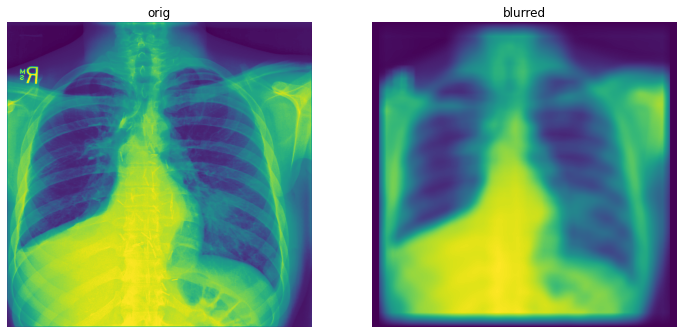

In [27]:
ims = xray_sample.hist_scaled(), uniform_blur2d(xray_sample.hist_scaled(),50)
show_images(ims, titles=('orig', 'blurred'), figsize=(12, 6))

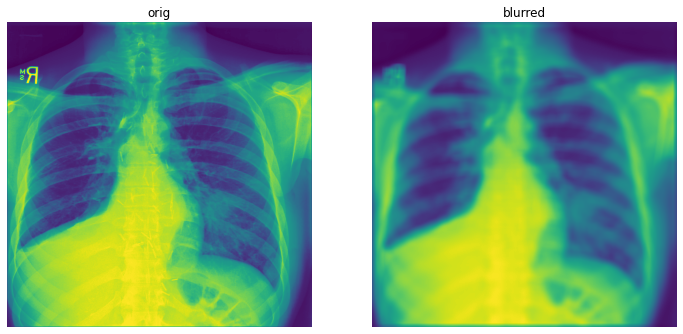

In [28]:
ims = xray_sample.hist_scaled(), gauss_blur2d(xray_sample.hist_scaled(),50)
show_images(ims, titles=('orig', 'blurred'), figsize=(12, 6))

In [0]:
# xray_sample.mask_from_blur??

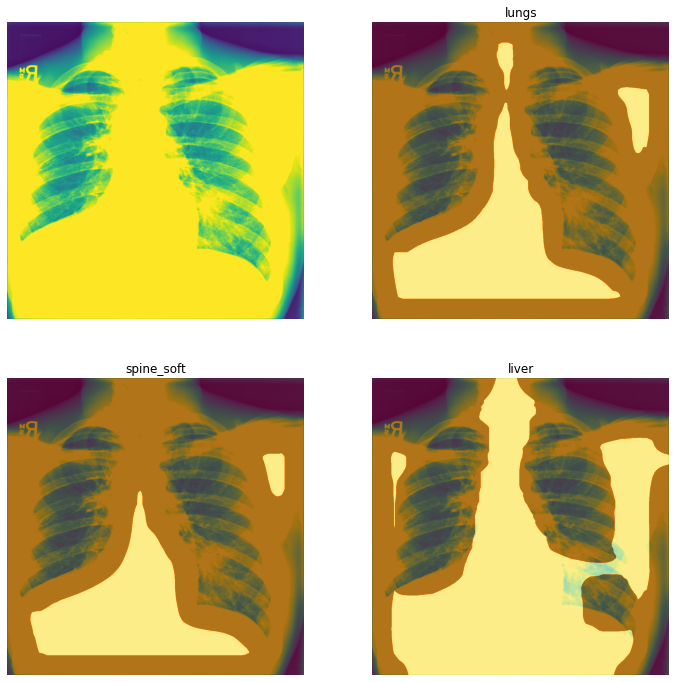

In [30]:
wind = xray_sample.windowed(*dicom_windows.lungs)
mask1 = xray_sample.mask_from_blur(dicom_windows.lungs)
mask2 = xray_sample.mask_from_blur(dicom_windows.spine_soft)
mask3 = xray_sample.mask_from_blur(dicom_windows.liver)

_,ax = subplots(2,2, figsize=(12, 12))
ax = ax.reshape(-1)
show_image(wind, ax=ax[0])
show_image(wind, ax=ax[1])
show_image(wind, ax=ax[2])
show_image(wind, ax=ax[3])

show_image(mask1, alpha=0.5, cmap=plt.cm.Reds, ax=ax[1], title="lungs");
show_image(mask2, alpha=0.5, cmap=plt.cm.Reds, ax=ax[2], title="spine_soft");
show_image(mask3, alpha=0.5, cmap=plt.cm.Reds, ax=ax[3], title="liver");

แต่ดวงตาของมนุษย์ และการแสดงผลบนจอภาพแบบขาวดำ ยังไงก็มีข้อจำกัด มีแนวคิดที่จะใช้การแสดงผลแบบสี RGB เข้ามาช่วยให้เหมาะกับการแสดงผลของจอภาพ และอำนวยความสะดวกกับดวงตามนุษย์มากขึ้น

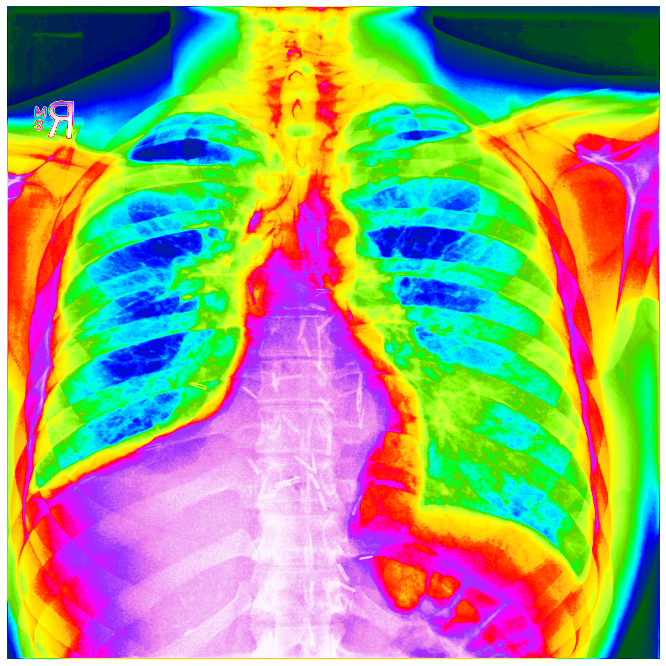

In [31]:
xray_sample.show(cmap=plt.cm.gist_ncar, figsize=(12, 12))

## 4.7 Bounding Box

เราสามารถสร้าง Bounding Box จาก Mask ได้ เพื่อไปใช้ในงาน [Object Detection](https://www.bualabs.com/archives/3453/what-is-object-detection-tutorial-tensorflow-js-build-object-detection-machine-learning-coco-ssd-tfjs-ep-8/) เป็นต้น

In [32]:
mask = xray_sample.mask_from_blur(dicom_windows.stroke)
bbs = mask2bbox(mask)
bbs

tensor([[   0,  895],
        [ 986, 1023]], device='cuda:0')

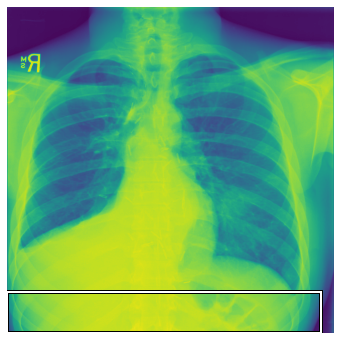

In [33]:
timg = TensorImage(xray_sample.scaled_px)
tbbox = TensorBBox(bbs.reshape(-1, 4))
ctx = timg.show(figsize=(6, 6))
tbbox.show(ctx=ctx);

# 5. Data Pipeline

## 5.1 Data Preparation

ดูไฟล์ที่เก็บ Label 

In [34]:
df = pd.read_csv(path/'train-rle.csv')
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1002 21 1002 20 1003 20 1002 21 1001 23 1000 23 999 24 999 24 999 23 999 24 999 24 998 26 996 27 995 28 995 28 994 30 993 30 993 30 993 30 993 31 992 31 992 31 992 31 992 32 990 33 990 33 990 33 991 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 993 30 993 30 993 30 993 30 994 29 994 29 994 30 993 30 994 29 994 30 993 30 993 31 993 31 992 31 992...
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24 999 25 999 25 999 26 997 27 997 27 996 28 996 28 996 29 994 30 994 30 994 30 993 31 993 32 992 32 992 32 992 32 991 33 991 33 991 33 991 33 991 33 990 34 990 34 990 34 990 34 990 34 989 35 989 36 988 36 988 16 1 19 988 15 3 18 988 15 4 16 989 14 8 13 989 14 8 13 989 13 9 13 989 13 9 13 989 12 10 13 989 12 10 13 989 11 11 13 989 11 11 13 989 11 11 13 989 10 11 14 989 10 11 14 990 9 9 16 990 9 7 18 990 9 6 18 991 9 6 18 991 9 5 19 992 8 4 20 992 7 5 20 993 6 4 21 993 6 4 21 994 4 4 22 995 3 5 20 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 12 1010 12 1011 12 1010 13 1009 14 1008 15 1008 15 1007 16 1007 16 1006 17 1006 17 1005 17 1005 18 1004 19 1004 18 1004 19 1004 19 1002 21 1001 22 1001 22 1000 23 1000 23 999 24 997 26 997 25 997 26 997 26 997 26 996 27 996 27 996 27 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 28 995 28 995 28 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 30 993 30 993 30 994 29 994 28 995 28 995 28 994 30 993 30 993 30 994 29 994 30 993 30 993 30 994 30 993 30 993 30 993 31 992 31 992 32 991 32 9...


Dataset นี้เป็นงาน [Segmentation](https://www.bualabs.com/archives/835/what-is-image-segmentation-semantic-segmentation-camvid-machine-learning-unet-deep-learning-image-segmentation-ep-1/) ใน Column EncodedPixels จะมีระบุว่า Pixel ไหนบ้างที่เป็นส่วนของ [Pneumothorax](https://www.bualabs.com/archives/tag/pneumothorax/) ถ้าไม่ป่วยจะเป็น -1 

เราจะแปลงให้เป็นงาน [Classification](https://www.facebook.com/bualabs/posts/228883361797333/) ด้วยการสร้าง Column ใหม่

มีข้อมูลบางส่วน Duplicate เราจะ Remove ออกไป

In [0]:
# sorting by first name 
df.sort_values("ImageId", inplace = True) 
  
# dropping ALL duplicte values 
df.drop_duplicates(subset ="ImageId", 
                     keep = 'first', inplace = True) 
  

ไม่ใช่ -1 แต่เป็น ' -1' มี space อยู่ด้านหน้าด้วย

In [36]:
df.iloc[1, 1]

' -1'

สร้าง Column ใหม่ จากเงื่อนไข -1 = Normal ถ้าไม่ใช่แสดงว่าป่วยเป็น Pneumothorax

In [37]:
df.loc[df.iloc[:, 1] == ' -1', 'label'] = "Normal"
df.loc[df.iloc[:, 1] != ' -1', 'label'] = "Pneumothorax"

df.sample(5)

,ImageId,EncodedPixels,label
8045,1.2.276.0.7230010.3.1.4.8323329.539.1517875163.351603,-1,Normal
10781,1.2.276.0.7230010.3.1.4.8323329.13373.1517875244.901243,-1,Normal
6268,1.2.276.0.7230010.3.1.4.8323329.4344.1517875182.377198,-1,Normal
7873,1.2.276.0.7230010.3.1.4.8323329.3731.1517875179.190313,-1,Normal
3932,1.2.276.0.7230010.3.1.4.8323329.1084.1517875166.254101,205351 1 1017 6 1012 11 1007 15 1004 17 900 120 869 152 821 200 821 200 785 235 785 235 786 234 787 234 788 233 789 233 780 241 777 244 777 241 780 239 783 238 785 237 786 235 787 235 787 234 785 235 787 222 801 218 804 184 839 148 875 145 877 142 881 141 882 140 883 138 884 137 886 134 889 132 890 132 891 131 891 131 891 130 893 129 893 129 893 130 892 131 891 131 891 132 891 131 891 132 891 131 892 130 893 129 894 128 895 127 896 126 897 124 899 123 899 123 900 121 902 119 904 118 905 117 906 116 908 115 908 114 909 114 909 113 911 112 911 111 912 111 912 110 913 109 914 109 915 108 915...,Pneumothorax


Drop Column ที่ไม่เกี่ยวข้องทิ้งไป

In [38]:
df = df.drop(df.columns[[1]], axis=1)
df.head()

,ImageId,label
5667,1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027,Normal
8268,1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530,Normal
8707,1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580,Normal
11189,1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397,Normal
8802,1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420,Normal


## 5.2 Exploratory Data Analysis (EDA)

สำรวจข้อมูล จะเห็นว่า Class Imbalance ประมาณ 8 ต่อ 2

In [39]:
df['label'].value_counts()

Normal          8296
Pneumothorax    2379
Name: label, dtype: int64

In [40]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312']

,ImageId,label
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,Pneumothorax


In [41]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312'].label.values[0]

'Pneumothorax'

In [42]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530'].label.values[0]

'Normal'

## 5.3 DataBlock

มีบางอันไม่ Match ให้ Default เป็น Normal

In [0]:
def label_func(fn):        
    lbl = df[df['ImageId'] == fn.stem].label.to_numpy()
    if len(lbl) == 0 : return "Normal"
    return lbl[0]

สร้าง [DataBlock](https://www.bualabs.com/archives/2693/what-is-data-pipeline-data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) และ [DataLoader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) โดยทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ตาม Default ยกเว้นการ Flip เนื่องจากฟิล์ม X-Ray ไม่มีกลับหัว และถูกถ่ายจากด้านหน้าเท่านั้น

In [0]:
def getDataLoaders(bs, size):
    pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock), 
                         get_items=get_dicom_files, 
                         get_y=label_func, 
                         batch_tfms=[*aug_transforms(do_flip=False, size=size)]
                         )
    # pneumothorax.summary(path/'dicom-images-train')
    dls = pneumothorax.dataloaders(path/'dicom-images-train', bs=bs)
    return dls    

สร้าง DataLoader ด้วย size 224 และ [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) 64 แล้วแสดงข้อมูลตัวอย่าง ใน Batch 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


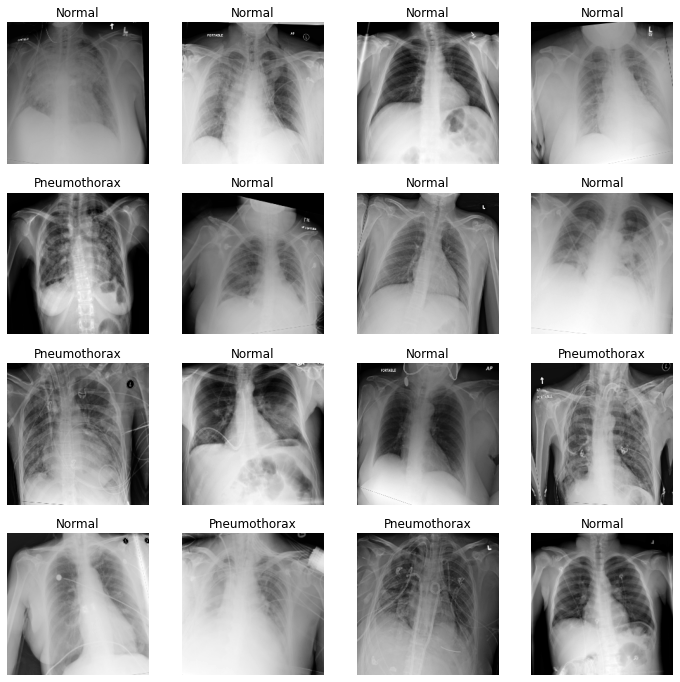

In [45]:
dls = getDataLoaders(64, 224)
dls.show_batch(max_n=16)

เช็คว่ามี 2 Class

In [46]:
dls.vocab

(#2) ['Normal','Pneumothorax']

# 6. Model

เนื่องจาก Class Imbalance เราจะใช้ [Focal Loss](https://www.bualabs.com/archives/4227/what-is-focal-loss-loss-function-ep-4/)

In [0]:
class XFocalLoss(kornia.losses.FocalLoss):
    y_int = True
    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(XFocalLoss, self).__init__(alpha, gamma, reduction)

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:       

        # set_trace()
        # print(input.shape)
        # print(target.shape)
        return super().forward(input, target)      

    def decodes(self, x):    return x.argmax(dim=1)
    def activation(self, x): return F.softmax(x, dim=1)               

In [0]:
loss_func = XFocalLoss(alpha=1.0, gamma=2.0, reduction='mean')

ใช้ [Convolutional Neural Network](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) สถาปัตยกรรม [ResNet34](https://www.bualabs.com/archives/482/resnet34-vs-resnet50-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-2/)

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    loss_func=loss_func, opt_func=ranger, 
                    cbs=[ShowGraphCallback])

# 7. Train

## 7.1 Fine-tune

เริ่มต้นเทรนเรียก Fine-Tune ให้เทรน 2 Step

epoch,train_loss,valid_loss,accuracy,time
0,0.897424,0.371453,0.602708,01:42
1,0.663855,0.231189,0.711951,01:43
2,0.466633,0.194975,0.776844,01:44
3,0.298959,0.164467,0.778245,01:41
4,0.191545,0.122646,0.785247,01:39
5,0.138676,0.112289,0.795051,01:39


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


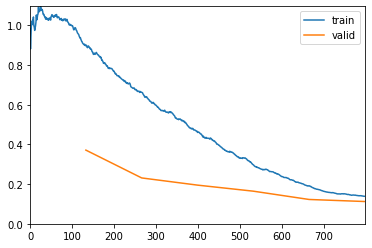

epoch,train_loss,valid_loss,accuracy,time
0,0.119404,0.103826,0.816993,01:40
1,0.109796,0.100087,0.820728,01:40
2,0.100498,0.093472,0.841737,01:39
3,0.091381,0.091147,0.840336,01:39
4,0.081206,0.095227,0.851074,01:39
5,0.069791,0.096116,0.847339,01:39
6,0.058541,0.101840,0.852007,01:39
7,0.049469,0.109456,0.853408,01:39
8,0.043493,0.116918,0.852007,01:40
9,0.038999,0.116353,0.851541,01:41


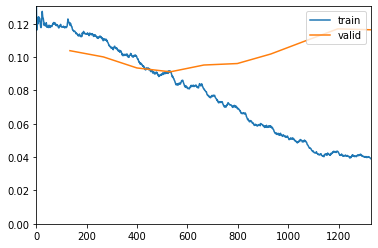

In [50]:
learn.fine_tune(10, freeze_epochs=6)

ได้ Accuracy 85.1% เซฟโมเดลไว้ก่อน

In [0]:
learn.save("224")

## 7.2 Progressive Resizing

สร้าง Data Loader ใหม่ด้วย size รูป 384 x 384 Pixel และ [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) เท่ากับ 64

In [52]:
dls = getDataLoaders(64, 384)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


สร้าง [Learner](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) ใหม่จาก [Data Loader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) ด้านบน

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    loss_func=loss_func, opt_func=ranger, 
                    cbs=[ShowGraphCallback])

โหลดโมเดล 224 ขึ้นมา

In [54]:
learn.load("224")

In [0]:
learn.freeze()

เทรนต่อ

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

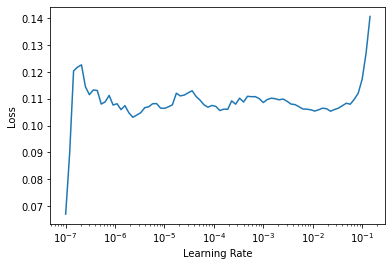

In [56]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.090619,0.078907,0.866947,01:47
1,0.086634,0.078116,0.875817,01:47
2,0.080762,0.077723,0.871148,01:46
3,0.076404,0.076881,0.868814,01:47


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


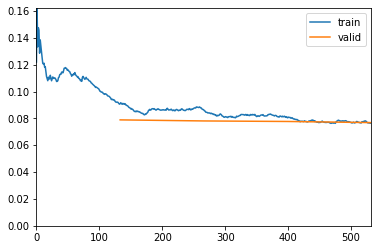

In [57]:
learn.fit_one_cycle(4, lr_max=slice(1e-3))

In [0]:
learn.save("384-1")

In [0]:
learn.load("384-1");

In [0]:
learn.unfreeze()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=1.0964781722577754e-06)

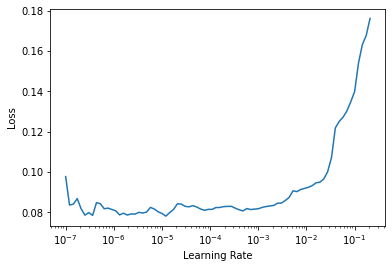

In [61]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.079409,0.076640,0.870682,01:54
1,0.076288,0.075950,0.876284,01:53
2,0.072573,0.075441,0.874416,01:56
3,0.068436,0.074546,0.876751,01:59
4,0.065383,0.075077,0.873950,01:57
5,0.063839,0.073830,0.879552,01:53
6,0.062193,0.073291,0.879552,01:55
7,0.058192,0.073861,0.880486,01:56
8,0.059698,0.073273,0.880486,01:57
9,0.055052,0.073578,0.879552,01:55


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


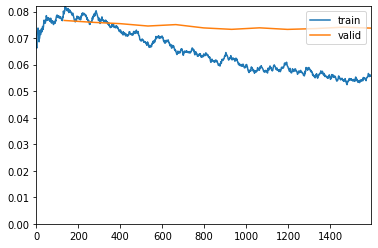

In [62]:
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

ได้ Accuracy 88.1% 

In [0]:
learn.save("384-2")

In [0]:
learn.load("384-2");

แสดงผลลัพธ์การทำงาน

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


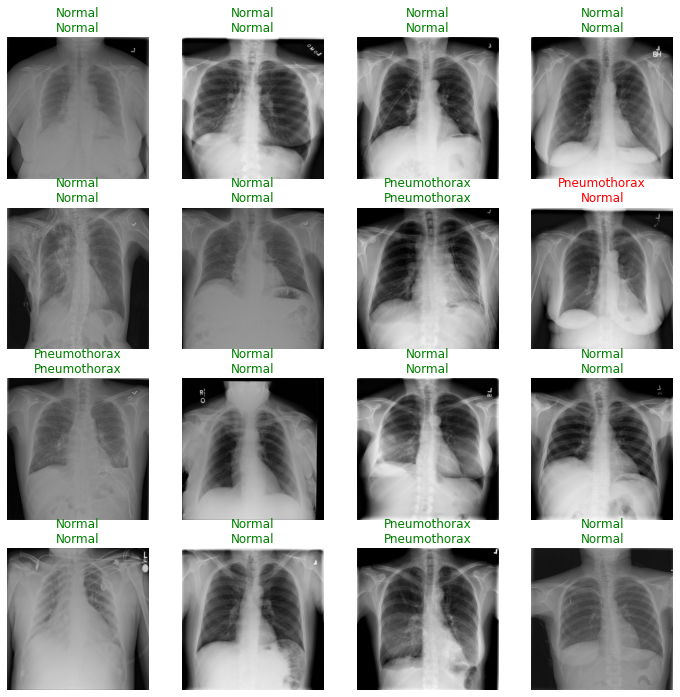

In [65]:
learn.show_results(max_n=16)

# 8. ตีความผลลัพธ์

เราจะใช้ คลาส ClassificationInterpretation ในการช่วยตีความผลการทำงานของโมเดล

In [66]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


พล็อต [Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/)

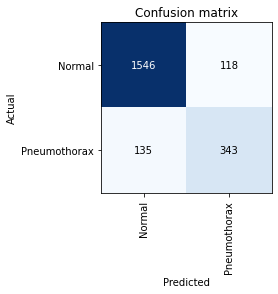

In [67]:
interp.plot_confusion_matrix()

แสดงสถิติที่เกี่ยวข้อง เช่น Precision, Recall

In [68]:
interp.print_classification_report()

              precision    recall  f1-score   support

      Normal       0.92      0.93      0.92      1664
Pneumothorax       0.74      0.72      0.73       478

    accuracy                           0.88      2142
   macro avg       0.83      0.82      0.83      2142
weighted avg       0.88      0.88      0.88      2142



แสดงรายการที่โมเดลทายผิดมากที่สุด

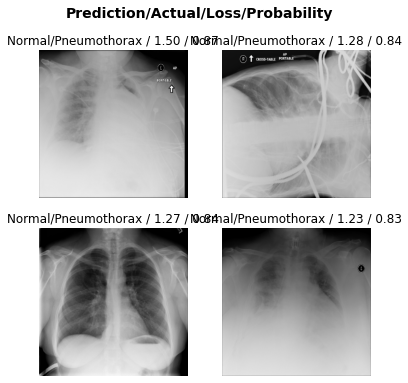

In [69]:
interp.plot_top_losses(4)

# Credit

* https://dev.fast.ai/medical.imaging
* https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai
* https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai
* https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data
* https://github.com/fastai/fastai2/blob/master/nbs/61_tutorial.medical_imaging.ipynb
* https://en.wikipedia.org/wiki/Hounsfield_scale